# CCG programming challenge
### by David Narganes

I will import the required libraries:

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import missingno as msno
import os

# 1. Exploratory analysis

Which files are in the folder I am working?

In [6]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 'CCGProgrammingChallenge.ipynb',
 'Data Science unsupervised exercise.docx',
 'data_clinical_patient.txt',
 'data_expression.txt']

## 1.1 Metadata

Open the metadata file and have a first look at it:

In [93]:
metadata = pd.read_table('data_clinical_patient.txt')
metadata.shape

(2513, 20)

What variables are stored in the columns?

In [94]:
metadata.columns

Index(['#Patient Identifier', 'Overall Survival (Months)',
       'Overall Survival Status', 'Patient's Vital Status',
       'Integrative Cluster', 'Cohort', 'Age at Diagnosis',
       'Primary Tumor Laterality', 'Nottingham prognostic index',
       'ER status measured by IHC', 'Inferred Menopausal State',
       'Type of Breast Surgery', 'Cellularity', 'HER2 status measured by SNP6',
       '3-Gene classifier subtype', 'Pam50 + Claudin-low subtype',
       'Chemotherapy', 'Hormone Therapy', 'Radio Therapy',
       'Tumor Other Histologic Subtype'],
      dtype='object')

I will make a nicer dataframe without the information of the variables:

In [95]:
metadata2 = pd.DataFrame(metadata[4:].values, columns = metadata.loc[3].values)
metadata2.head()

,PATIENT_ID,OS_MONTHS,OS_STATUS,VITAL_STATUS,INTCLUST,COHORT,AGE_AT_DIAGNOSIS,LATERALITY,NPI,ER_IHC,INFERRED_MENOPAUSAL_STATE,BREAST_SURGERY,CELLULARITY,HER2_SNP6,THREEGENE,CLAUDIN_SUBTYPE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,HISTOLOGICAL_SUBTYPE
0,MB-0000,140.5,LIVING,Living,4ER+,1,75.65,r,6.044,pos,post,MASTECTOMY,null,NEUT,ER-/HER2-,claudin-low,NO,YES,YES,IDC
1,MB-0002,84.63333333,LIVING,Living,4ER+,1,43.19,r,4.02,pos,pre,BREAST CONSERVING,high,NEUT,ER+/HER2- High Prolif,LumA,NO,YES,YES,IDC
2,MB-0005,163.1,DECEASED,Died of Disease,3,1,48.87,r,4.03,pos,pre,MASTECTOMY,high,NEUT,null,LumB,YES,YES,NO,IDC
3,MB-0006,164.9333333,LIVING,Living,9,1,47.68,r,4.05,pos,pre,MASTECTOMY,moderate,NEUT,null,LumB,YES,YES,YES,IDC
4,MB-0008,41.36666667,DECEASED,Died of Disease,9,1,76.97,r,6.08,pos,post,MASTECTOMY,high,NEUT,ER+/HER2- High Prolif,LumB,YES,YES,YES,IDC


## 1.2.1 Missing data in `metadata`
What is the percentage of missing data per feature in the `metadata`?

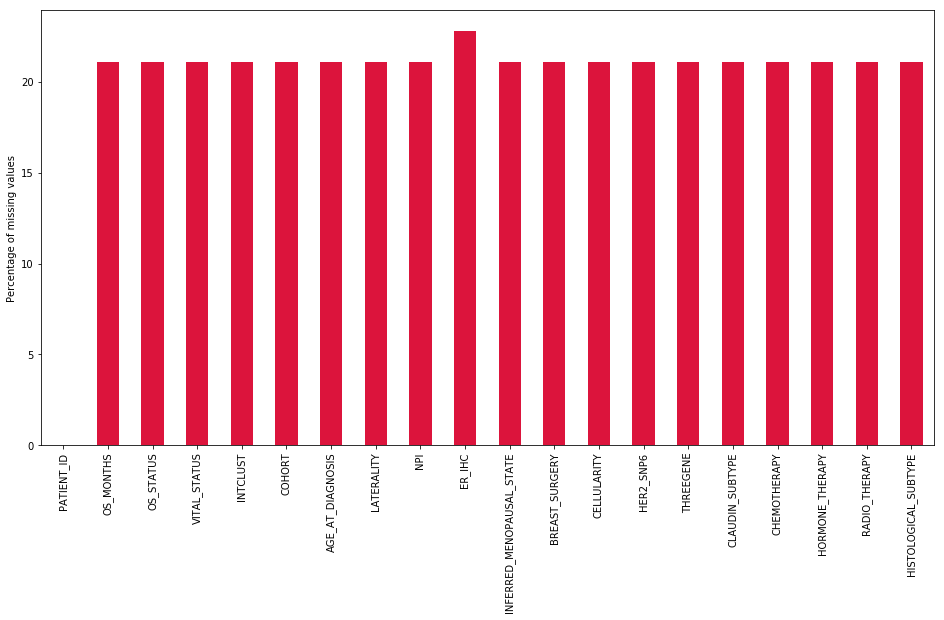

In [42]:
(metadata2.isnull().mean()*100).plot.bar(figsize = (16,8), color = 'crimson')
plt.ylabel('Percentage of missing values')
plt.show()

How is the missing pattern? Are values missing at random or not?

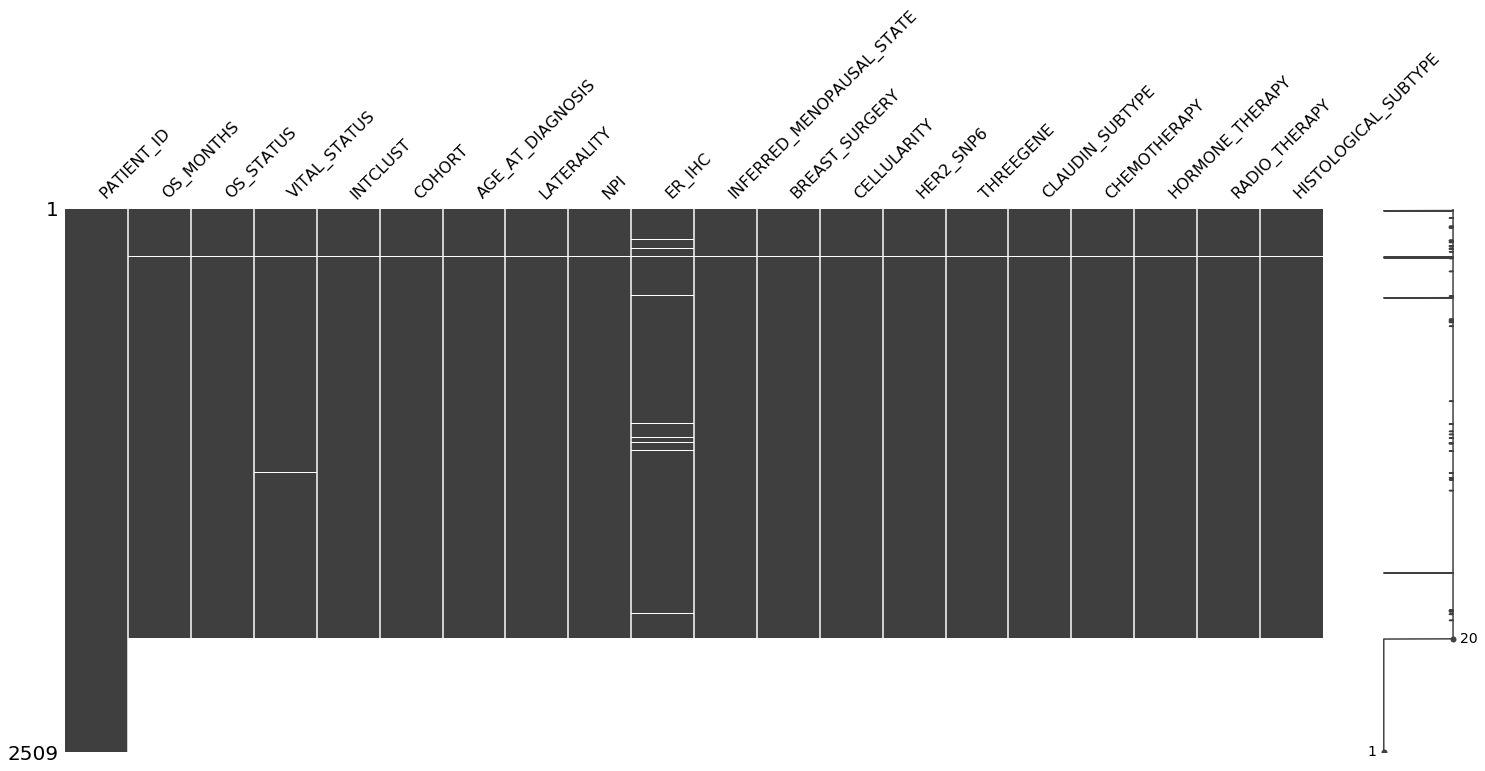

In [43]:
msno.matrix(metadata2)
plt.show()

How correlated is the missingness of metadata?

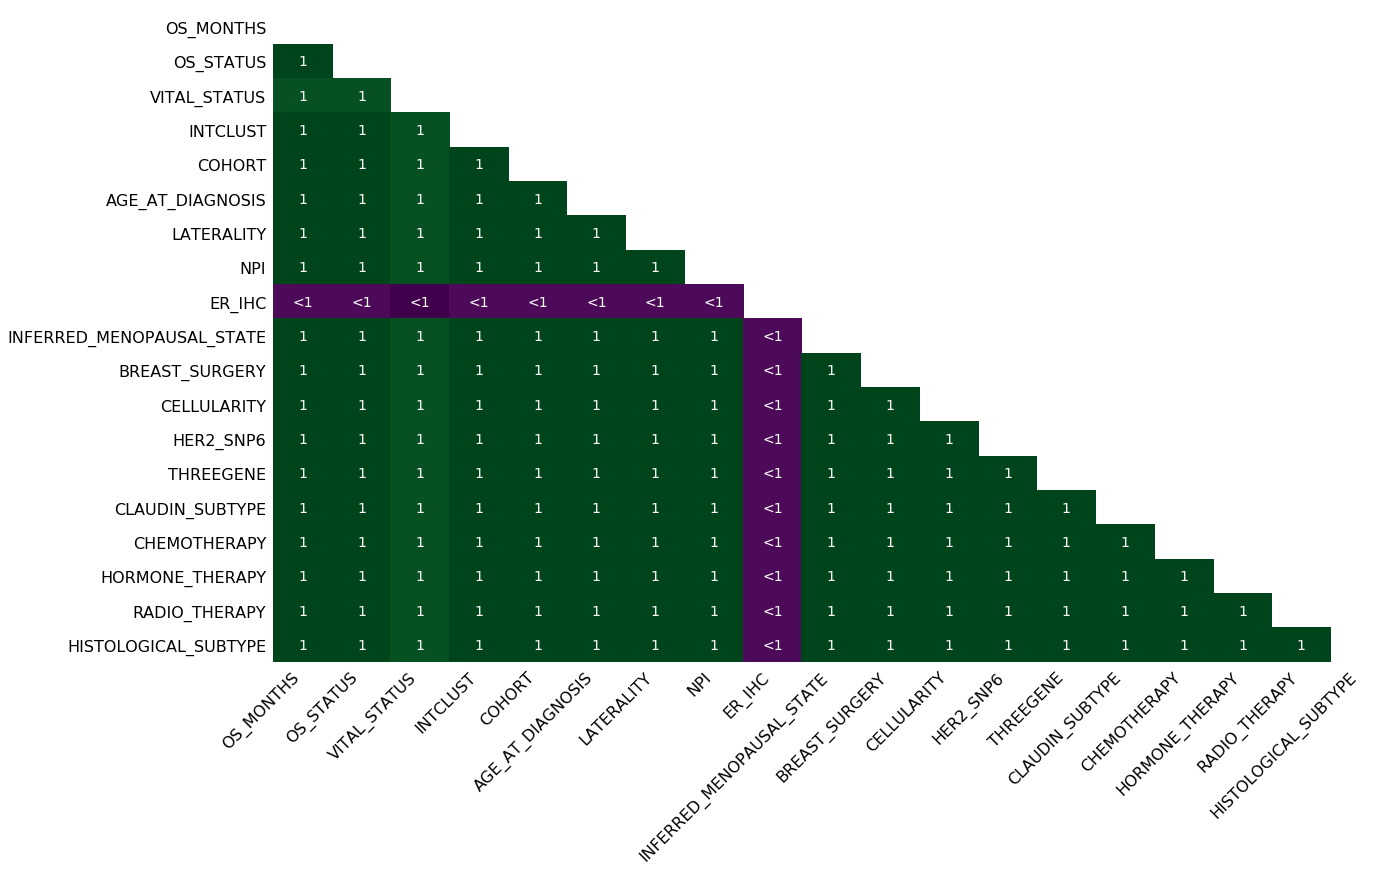

In [44]:
msno.heatmap(metadata2, cmap = 'PRGn')
plt.show()

Okay, the missingness is correlated (1 Pearson coefficient) for all the variables: this is, the patients that don't have a record for one of the variables (e.g. OS_Months) don't have a record for the remaining variables.

Let's confirm this with the dendrogram:

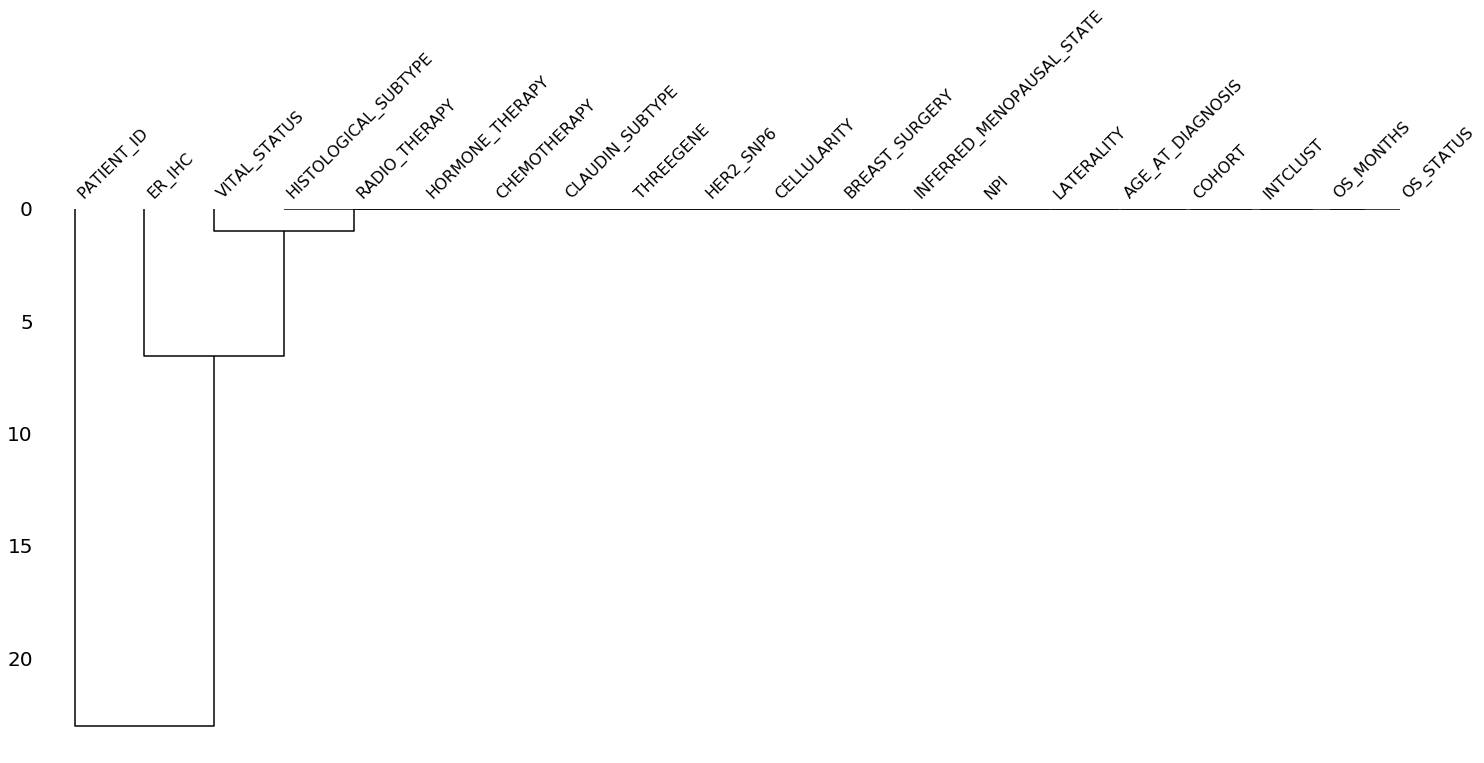

In [45]:
msno.dendrogram(metadata2)
plt.show()

1. There's a `PATIENT_ID` for all patients.
2. If `HISTOLOGICAL_SUBTYPE` is missing, the remaining variables on the right are also missing.

## 1.2.2. Outcomes
Which are the outcomes?

In [48]:
metadata2[metadata2.columns[0:4]].head()

,PATIENT_ID,OS_MONTHS,OS_STATUS,VITAL_STATUS
0,MB-0000,140.5,LIVING,Living
1,MB-0002,84.63333333,LIVING,Living
2,MB-0005,163.1,DECEASED,Died of Disease
3,MB-0006,164.9333333,LIVING,Living
4,MB-0008,41.36666667,DECEASED,Died of Disease


How many different values in the different outcomes?

In [51]:
metadata2.OS_STATUS.value_counts()

DECEASED    1143
LIVING       837
Name: OS_STATUS, dtype: int64

In [52]:
metadata2.VITAL_STATUS.value_counts()

Living                  837
Died of Disease         646
Died of Other Causes    496
Name: VITAL_STATUS, dtype: int64

## 1.3 Data

Open the gene expression file:

In [53]:
%%time
data = pd.read_table('data_expression.txt')

Wall time: 11.6 s


In [54]:
data.shape

(24368, 1906)

Which is the `PATIENT_ID`?

In [58]:
patients = data.columns[2:]
patients

Index(['MB-0362', 'MB-0346', 'MB-0386', 'MB-0574', 'MB-0503', 'MB-0641',
       'MB-0201', 'MB-0218', 'MB-0316', 'MB-0189',
       ...
       'MB-6122', 'MB-6192', 'MB-4820', 'MB-5527', 'MB-5167', 'MB-5465',
       'MB-5453', 'MB-5471', 'MB-5127', 'MB-4313'],
      dtype='object', length=1904)

At a first glance, there are more patients with metadata (index of metadata) than patients with gene expression mesurements (columns of data)

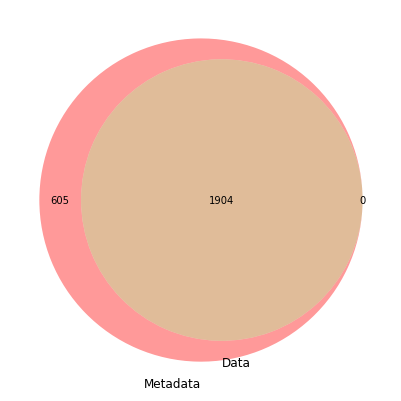

In [61]:
patients_meta = set(metadata2.PATIENT_ID)
patients_data = set(patients)

# Make the diagram
plt.figure(figsize = (7,7))
venn2(subsets = (patients_meta,patients_data),
      set_labels = ('Metadata', 'Data'),
     )
plt.show()

605 patients included in `Metadata` aren't in `Data`

## 1.4. Merge `data` and `metadata` and explore

I will keep `Hugo_Symbol` as the name of the genes and transpose:

In [97]:
data2 = data.drop(['Entrez_Gene_Id','Hugo_Symbol'], axis = 1)
data3 = data2.transpose()
data3.columns = data.Hugo_Symbol

In [101]:
data4 = data3.reset_index().rename(columns = {'index':'PATIENT_ID'})
data4.shape

(1904, 24369)

Merge based on `PATIENT_ID`: I will just work with the patients with an identifier

In [128]:
df = data4.merge(metadata2, on = ['PATIENT_ID'], how = 'inner')
df.shape

(1904, 24388)

## 1.4.1 Missing data in `merged`

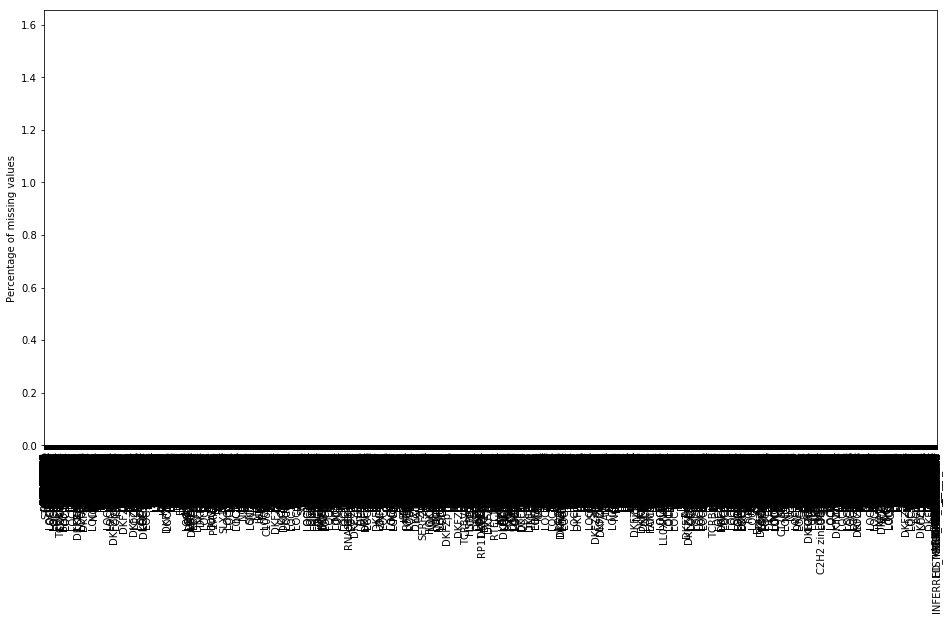

In [129]:
(df.isnull().mean()*100).plot.bar(figsize = (16,8), color = 'crimson')
plt.ylabel('Percentage of missing values')
plt.show()

I can't really see anything, I will sort variables based on the percentage of missing values:

In [142]:
df.isnull().mean().sort_values(ascending = False).head(n = 13)

ER_IHC          0.015756
CSNK2A1         0.001050
SLC25A19        0.001050
AK127905        0.000525
VITAL_STATUS    0.000525
MRPL24          0.000525
BAMBI           0.000525
IDO1            0.000525
TMPRSS7         0.000525
FAM71A          0.000525
MYLK3           0.000000
BU741055        0.000000
BM984149        0.000000
dtype: float64

There are several variables with a low percentage (less than 2%) of missing values that could be imputed

## 1.5 Analyse outcomes

In [136]:
df.columns[-20:]

Index(['FAM71A', 'OS_MONTHS', 'OS_STATUS', 'VITAL_STATUS', 'INTCLUST',
       'COHORT', 'AGE_AT_DIAGNOSIS', 'LATERALITY', 'NPI', 'ER_IHC',
       'INFERRED_MENOPAUSAL_STATE', 'BREAST_SURGERY', 'CELLULARITY',
       'HER2_SNP6', 'THREEGENE', 'CLAUDIN_SUBTYPE', 'CHEMOTHERAPY',
       'HORMONE_THERAPY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE'],
      dtype='object')

In [143]:
outcomes = ['PATIENT_ID','OS_MONTHS','VITAL_STATUS','OS_STATUS']
df[outcomes].head()

,PATIENT_ID,OS_MONTHS,VITAL_STATUS,OS_STATUS
0,MB-0362,47.03333333,Died of Disease,DECEASED
1,MB-0346,20.43333333,Died of Disease,DECEASED
2,MB-0386,138.1333333,Living,LIVING
3,MB-0574,119.8,Living,LIVING
4,MB-0503,101.2333333,Living,LIVING


Since the aim of this programming challenge is to predict death from disease within 36 months, I will consider the outcome as the joint of `OS_MONTHS` < 36 AND `VITAL_STATUS` == `Died of Disease`. The variable `OS_STATUS` is not relevant.

In [158]:
df['y'] = (df.OS_MONTHS.astype(float) > 36) & (df.VITAL_STATUS == 'Died of Disease')

print(df.y.value_counts())

to_print = df.y.value_counts()[1]/df.y.value_counts()[0]*100
print('\nThe imbalace in ratio', to_print)

False    1454
True      450
Name: y, dtype: int64

The imbalace in ratio 30.9491059147


In [165]:
discard = ['PATIENT_ID','OS_MONTHS','OS_STATUS','VITAL_STATUS']
df2 = df.copy(deep = True).drop(discard, axis = 1)

Here is the imbalance, a model will have to be able when patients die. A simple model which always predicts that all patients will die will be a relatively good model

## 2. Preprocessing

Which variables will have to be converted to dummy? Which variables are `object`?

In [305]:
print(df2.dtypes[df2.dtypes != 'float'])
dtypes = df2.dtypes[df2.dtypes == 'object'].index

INTCLUST                     object
COHORT                       object
LATERALITY                   object
ER_IHC                       object
INFERRED_MENOPAUSAL_STATE    object
BREAST_SURGERY               object
CELLULARITY                  object
HER2_SNP6                    object
THREEGENE                    object
CLAUDIN_SUBTYPE              object
CHEMOTHERAPY                 object
HORMONE_THERAPY              object
RADIO_THERAPY                object
HISTOLOGICAL_SUBTYPE         object
y                              bool
dtype: object


`NPI`, `AGE_AT_DIAGNOSIS` are continuous

In [180]:
continuous = ['NPI','AGE_AT_DIAGNOSIS']
df2[continuous] = df2[continuous].astype(float)

I want to include the metadata variables to see if they are predictive or not. I also want to check if some variables are binary, semicontinuous (even if they are discrete, there is an order like 0<1<2<3) or categorical

In [218]:
for i in dtypes:
    print(df2[i].value_counts())
    print('_______________________________________________')

8       289
3       282
4ER+    244
10      219
5       184
7       182
9       142
1       132
6        84
4ER-     74
2        72
Name: INTCLUST, dtype: int64
_______________________________________________
3    734
1    481
2    286
4    236
5    167
Name: COHORT, dtype: int64
_______________________________________________
l       935
r       863
null    106
Name: LATERALITY, dtype: int64
_______________________________________________
pos    1445
neg     429
Name: ER_IHC, dtype: int64
_______________________________________________
post    1493
pre      411
Name: INFERRED_MENOPAUSAL_STATE, dtype: int64
_______________________________________________
MASTECTOMY           1127
BREAST CONSERVING     755
null                   22
Name: BREAST_SURGERY, dtype: int64
_______________________________________________
high        939
moderate    711
low         200
null         54
Name: CELLULARITY, dtype: int64
_______________________________________________
NEUT     1383
GAIN      417
LOSS

I don't know how to use `HISTOLOGICAL_SUBTYPE` nor `INTCLUST` so I will discard them in my analyses.

All the remaining object varibles will be converted to dummy

In [242]:
list(dtypes)

['INTCLUST',
 'COHORT',
 'LATERALITY',
 'ER_IHC',
 'INFERRED_MENOPAUSAL_STATE',
 'BREAST_SURGERY',
 'CELLULARITY',
 'HER2_SNP6',
 'THREEGENE',
 'CLAUDIN_SUBTYPE',
 'CHEMOTHERAPY',
 'HORMONE_THERAPY',
 'RADIO_THERAPY',
 'HISTOLOGICAL_SUBTYPE']

In [250]:
col_names = list(dtypes)[1:-1]

In [256]:
pd.get_dummies(df2, columns = col_names).columns[-50:]

Index(['CB986545', 'IGSF9', 'DA110839', 'FAM71A', 'INTCLUST',
       'AGE_AT_DIAGNOSIS', 'NPI', 'HISTOLOGICAL_SUBTYPE', 'y', 'COHORT_1',
       'COHORT_2', 'COHORT_3', 'COHORT_4', 'COHORT_5', 'LATERALITY_l',
       'LATERALITY_null', 'LATERALITY_r', 'ER_IHC_neg', 'ER_IHC_pos',
       'INFERRED_MENOPAUSAL_STATE_post', 'INFERRED_MENOPAUSAL_STATE_pre',
       'BREAST_SURGERY_BREAST CONSERVING', 'BREAST_SURGERY_MASTECTOMY',
       'BREAST_SURGERY_null', 'CELLULARITY_high', 'CELLULARITY_low',
       'CELLULARITY_moderate', 'CELLULARITY_null', 'HER2_SNP6_GAIN',
       'HER2_SNP6_LOSS', 'HER2_SNP6_NEUT', 'HER2_SNP6_UNDEF',
       'THREEGENE_ER+/HER2- High Prolif', 'THREEGENE_ER+/HER2- Low Prolif',
       'THREEGENE_ER-/HER2-', 'THREEGENE_HER2+', 'THREEGENE_null',
       'CLAUDIN_SUBTYPE_Basal', 'CLAUDIN_SUBTYPE_Her2', 'CLAUDIN_SUBTYPE_LumA',
       'CLAUDIN_SUBTYPE_LumB', 'CLAUDIN_SUBTYPE_NC', 'CLAUDIN_SUBTYPE_Normal',
       'CLAUDIN_SUBTYPE_claudin-low', 'CHEMOTHERAPY_NO', 'CHEMOTHERAPY_YES

I know that some of them are redundant like `RADIO_THERAPY_NO` and `RADIO_THERAPY_YES` but I will leave them to see the results in the model.

In [322]:
discard = ['HISTOLOGICAL_SUBTYPE','INTCLUST']
df3 = pd.get_dummies(df2.copy(deep = True), columns = col_names).drop(discard, axis = 1)
df3.shape

(1904, 24412)

In [323]:
df4 = df3.copy(deep = True).astype(float)
print(df4.dtypes[df4.dtypes != 'float'])

Series([], dtype: object)


## 2.1 Standarisation
All features will have to be in the same scale to compare their weights in the different models

In [324]:
def standarise_features(df):
    for i in df.columns:
        s = df[i]
        df[i] = s.sub(s.min()).div((s.max() - s.min()))
        
    return(df)

In [325]:
df5 = standarise_features(df4.copy(deep = True))

## 2.1 Imputation
There are some variables with low percentage of missing data. This is the order:

In [327]:
(df5.isnull().mean()*100).sort_values(ascending = False).head(n= 10)

CSNK2A1      0.105042
SLC25A19     0.105042
BAMBI        0.052521
AK127905     0.052521
IDO1         0.052521
FAM71A       0.052521
TMPRSS7      0.052521
MRPL24       0.052521
PRAM1        0.000000
NIPSNAP3A    0.000000
dtype: float64

I will use MICE (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/) to impute the missing values and I will create latent variables for the missingness to see if the missingness is important in the subsequent models:

In [328]:
forLatent = list((df5.isnull().mean()*100).sort_values(ascending = False).index[0:8])

In [329]:
def addLatent(df, var):
    for i in var:
        string = i+'lat'
        df[string] = df[i].isnull()
        print('%-15s ...finished' % string)
    return(df)        

In [330]:
df6 = addLatent(df5.copy(deep=True), var = forLatent)

CSNK2A1lat      ...finished
SLC25A19lat     ...finished
BAMBIlat        ...finished
AK127905lat     ...finished
IDO1lat         ...finished
FAM71Alat       ...finished
TMPRSS7lat      ...finished
MRPL24lat       ...finished


I will release some RAM by saving and importing again:

In [332]:
df6.to_csv('df6.csv', index = False)

Restart! and load libraries again

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
import scipy.stats as st
import fancyimpute
import numpy as np
import scipy as sp
import scipy.stats

#df6 = pd.read_csv('df6.csv')
idf6 = pd.read_csv('idf6.csv')

Using TensorFlow backend.


Multiple imputation is a process where the missing values are filled multiple times to create “complete” datasets. Multiple imputation has a lot of advantages over traditional single imputation methods. Multiple Imputation by Chained Equations (MICE) is an imputation method that works with the assumption that the missing data are Missing at Random (MAR). Recall that for MAR, the nature of the missing data is related to the observed data but not the missing data. The MICE algorithm works by running multiple regression models and each missing value is modeled conditionally depending on the observed (non-missing) values.

Detailed explanation: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/

Code: https://github.com/iskandr/fancyimpute/blob/master/fancyimpute/mice.py

I assume that the variables with missing values are continuous and therefore the MICE will use Ridge multiple regression with the `x` most predictive features for the variable with missing values

In [3]:
mice_res = fancyimpute.MICE(n_imputations = 10,
                        n_burn_in = 10,
                        n_nearest_columns = 10,
                        init_fill_method = 'median',
                        min_value = 0,
                        max_value = 1,
                       ).complete(df6.copy(deep = True).astype(float))

[MICE] Completing matrix with shape (1904, 24420)
[MICE] Starting imputation round 1/20, elapsed time 0.428
[MICE] Starting imputation round 2/20, elapsed time 20.667
[MICE] Starting imputation round 3/20, elapsed time 41.958
[MICE] Starting imputation round 4/20, elapsed time 65.675
[MICE] Starting imputation round 5/20, elapsed time 85.523
[MICE] Starting imputation round 6/20, elapsed time 103.668
[MICE] Starting imputation round 7/20, elapsed time 120.333
[MICE] Starting imputation round 8/20, elapsed time 136.992
[MICE] Starting imputation round 9/20, elapsed time 154.160
[MICE] Starting imputation round 10/20, elapsed time 170.804
[MICE] Starting imputation round 11/20, elapsed time 187.758
[MICE] Starting imputation round 12/20, elapsed time 204.580
[MICE] Starting imputation round 13/20, elapsed time 221.455
[MICE] Starting imputation round 14/20, elapsed time 238.219
[MICE] Starting imputation round 15/20, elapsed time 255.025
[MICE] Starting imputation round 16/20, elapsed ti

In [4]:
idf6 = pd.DataFrame(mice_res, columns = df6.columns)
#idf6.to_csv('idf6.csv', index = False)

## 3. Feature selection
I will use the Elastic Net regularisation with a balanced (asymmetric loss function with redefined weights) Logistic regression to combine the L1 and L2 penalties of the LASSO and ridge methods.

References:
1. https://en.wikipedia.org/wiki/Elastic_net_regularization
2. https://web.stanford.edu/~hastie/Papers/B67.2%20(2005)%20301-320%20Zou%20&%20Hastie.pdf
3. http://datavis.ca/papers/genridge-jcgs.pdf
4. https://arxiv.org/pdf/1509.09169.pdf

In [264]:
def regularisation_path(x,y,alphas,max_iter = 100):

    coefs = []
    for a in alphas:
        en = SGDClassifier(alpha = a,
                           penalty = 'elasticnet',
                           l1_ratio = 1e-2,
                           max_iter = max_iter,
                           random_state=0,
                           n_jobs = -1,
                           class_weight = 'balanced',
                          )
        
        en.fit(x, y)
        coefs.append(en.coef_[0])

    coefs_new = list(map(list, zip(*coefs)))
    
    return(coefs_new)

In [265]:
%%time
alphas = np.logspace(-5,-3,20)
coefs = regularisation_path(x = idf6.drop('y', axis = 1),
                            y = idf6.y,
                            alphas = alphas,
                            max_iter = 20,
                           )

Wall time: 3min 50s


I will just plot the first 100 variables to demonstrate the idea of the regularisation by increasing $\alpha$:

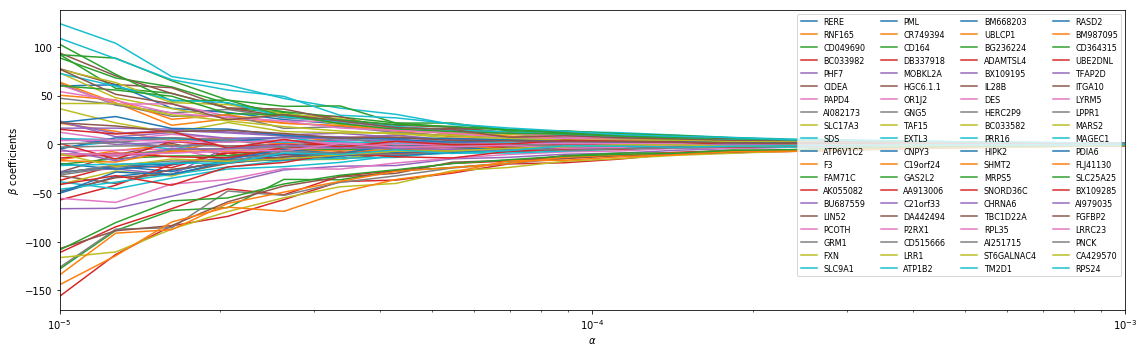

Wall time: 1.74 s


In [269]:
%%time
plt.figure(figsize = (16,5))
for i in range(80):
    plt.plot(alphas, coefs[i], label = idf6.columns[i])
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$ coefficients')
plt.xlim((alphas[0],alphas[-1]))
plt.legend(fontsize = 8, ncol=4, loc = 1)
plt.tight_layout()
plt.savefig('regularisation_path.pdf')
plt.show()

When alpha is very large, the regularization effect dominates the squared loss function and the coefficients tend to zero.

In [5]:
def confidence_intervals(a):
    result = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
    return(result)

I will use bootstrap resampling coupled with the balanced Logistic regression with regularisation so I can get measurements for the mean, std and confidence intervals

In [6]:
def elastic_bootstrap(df, dep, indep, n_iter, n_samples,
                      alpha = 5e-1, l1_ratio=5e-5, max_iter = 1e8, tol = 1e-9,
                     ):
    
    en = SGDClassifier(alpha = alpha,
                       penalty = 'elasticnet',
                       l1_ratio = l1_ratio,
                       max_iter = max_iter,
                       n_jobs = -1,
                       class_weight = 'balanced',
                       fit_intercept = True,
                      )
    coefs = []
    for i in range(n_iter):

        # Bootstrap
        dfr = resample(df, n_samples = n_samples)

        # Train bootstrapped df
        en.fit(dfr[dep], np.ravel(dfr[indep]))

        # Collect important values
        print('[Bootstrap] Iteration %d completed...' % i)
        coefs.append(en.coef_[0])
    
    print('Finished!')
    return(coefs)

In [7]:
dep = idf6.drop('y', axis = 1).columns

In [8]:
%%time
bcoefs = elastic_bootstrap(df = idf6,
                           dep = dep,
                           indep = ['y'],
                           n_iter = 50,
                           n_samples = len(idf6),
                           alpha = 1e-1,
                           l1_ratio = 1e-2,
                           max_iter = 100,
                           tol = 1e-9,
                          )

[Bootstrap] Iteration 0 completed...
[Bootstrap] Iteration 1 completed...
[Bootstrap] Iteration 2 completed...
[Bootstrap] Iteration 3 completed...
[Bootstrap] Iteration 4 completed...
[Bootstrap] Iteration 5 completed...
[Bootstrap] Iteration 6 completed...
[Bootstrap] Iteration 7 completed...
[Bootstrap] Iteration 8 completed...
[Bootstrap] Iteration 9 completed...
[Bootstrap] Iteration 10 completed...
[Bootstrap] Iteration 11 completed...
[Bootstrap] Iteration 12 completed...
[Bootstrap] Iteration 13 completed...
[Bootstrap] Iteration 14 completed...
[Bootstrap] Iteration 15 completed...
[Bootstrap] Iteration 16 completed...
[Bootstrap] Iteration 17 completed...
[Bootstrap] Iteration 18 completed...
[Bootstrap] Iteration 19 completed...
[Bootstrap] Iteration 20 completed...
[Bootstrap] Iteration 21 completed...
[Bootstrap] Iteration 22 completed...
[Bootstrap] Iteration 23 completed...
[Bootstrap] Iteration 24 completed...
[Bootstrap] Iteration 25 completed...
[Bootstrap] Iteration 

I am looking for features that have a constant Bcoef statistically different to 0 in all the bootstrap epochs. I will get the mean and std of the Bcoefs

In [9]:
bcoefs_df = pd.DataFrame(bcoefs, columns = dep)

I will create a dataframe to contain:
1. Mean
2. Standard deviation

The top features will be the ones whose mean is significantly different from 0 and whose std is small (similar expression levels in patients who die after 3 years). The top 30 features are:

In [10]:
(np.abs(bcoefs_df.mean()/bcoefs_df.std())).sort_values(ascending = False).head(n=30)

NPI                                 5.091047
C1orf113                            4.463703
COHORT_3                            4.287585
BREAST_SURGERY_MASTECTOMY           4.095610
BX110350                            3.910085
C11orf71                            3.830665
BREAST_SURGERY_BREAST CONSERVING    3.768842
TMUB1                               3.762818
GLIPR1L1                            3.749000
DA260147                            3.635626
DMRTC2                              3.470564
BG207080                            3.385897
FTL                                 3.352345
BX102319                            3.347791
BX505043                            3.341666
DB303280                            3.340854
C10orf47                            3.319505
BX090927                            3.298538
TREH                                3.280120
BU677460                            3.278140
CA398166                            3.273742
PUF60                               3.249222
IL1R2     

I can confirm that the Nottingham prognostic index (NPI) works indeed for predicting 3 year mortality from disease. The cohort 3 seems to be more likely to die as well as the ones who received chemotherapy (It's beta coefficient is positive whereas `CHEMOTHERAPY_NO` is negative).
The remaining features will be discussed later: chapter 7. Biological hypotesis.

I will store the `top_features` and `bottom_features` to use later and compare prediction models.

In [11]:
top_features = np.abs(bcoefs_df.mean()/bcoefs_df.std()).sort_values(ascending = False).index[:3000]
bottom_features = np.abs(bcoefs_df.mean()/bcoefs_df.std()).sort_values(ascending = False).index[-1000:]

Save features lists:

In [12]:
import pickle
# save top_features in a file
with open('top_features', 'wb') as fp:
    pickle.dump(top_features, fp)
with open('bottom_features', 'wb') as fp:
    pickle.dump(bottom_features, fp)

Import features lists:

In [15]:
import pickle
with open ('top_features', 'rb') as fp:
    top_features = pickle.load(fp)
with open ('bottom_features', 'rb') as fp:
    bottom_features = pickle.load(fp) 

Now I will define a simple OLS model with `statsmodels` with `top_features` and `bottom_features` to compare results:

In [21]:
import statsmodels.api as sm

exog = idf6[top_features[:200]]
endog = idf6.y

model = sm.OLS(endog = endog, exog = sm.add_constant(exog)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     7.521
Date:                Mon, 23 Apr 2018   Prob (F-statistic):          2.40e-130
Time:                        09:31:34   Log-Likelihood:                -471.63
No. Observations:                1904   AIC:                             1343.
Df Residuals:                    1704   BIC:                             2454.
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                1.0686      0.282      3.785      0.000       0.515       1.622
NPI                                  0.0762      0.045      1.690      0.091      -0.012       0.165
C1orf113                             0.1834      0.063      2.901      0.004       0.059       0.307
COHORT_3                            -0.0015      0.028     -0.055      0.956      -0.057       0.054
BREAST_SURGERY_MASTECTOMY            0.0903      0.075      1.199      0.231      -0.057       0.238
BX110350                            -0.1670      0.074     -2.261      0.024      -0.312      -0.022
C11orf71                            -0.2630      0.075     -3.510      0.000      -0.410      -0.116
BREAST_SURGERY_BREAST CONSERVING     0.0258      0.076      0.341      0.733      -0.123       0.174
TMUB1                                0.0340      0.074      0.460      0.646      -0.111       0.179
GLIPR1L1                             0.3033      0.108      2.815      0.005       0.092       0.515
DA260147                            -0.2326      0.072     -3.213      0.001      -0.375      -0.091
DMRTC2                               0.1421      0.067      2.120      0.034       0.011       0.274
BG207080                            -0.1697      0.071     -2.377      0.018      -0.310      -0.030
FTL                                  0.0875      0.084      1.036      0.300      -0.078       0.253
BX102319                            -0.2694      0.070     -3.852      0.000      -0.407      -0.132
BX505043                             0.1766      0.064      2.780      0.005       0.052       0.301
DB303280                            -0.2448      0.079     -3.118      0.002      -0.399      -0.091
C10orf47                            -0.1776      0.063     -2.835      0.005      -0.301      -0.055
BX090927                             0.1612      0.061      2.649      0.008       0.042       0.281
TREH                                -0.1281      0.067     -1.917      0.055      -0.259       0.003
BU677460                            -0.1332      0.064     -2.090      0.037      -0.258      -0.008
CA398166                             0.1721      0.062      2.779      0.006       0.051       0.294
PUF60                                0.0573      0.134      0.426      0.670      -0.206       0.321
IL1R2                               -0.1493      0.102     -1.465      0.143      -0.349       0.051
CHEMOTHERAPY_NO                      0.5170      0.142      3.650      0.000       0.239       0.795
TUBB2B                              -0.1043      0.056     -1.859      0.063      -0.214       0.006
DA145234                            -0.2576      0.069     -3.729      0.000      -0.393      -0.122
CHEMOTHERAPY_YES                     0.5516      0.14

In [23]:
exog = idf6[bottom_features[:200]]
endog = idf6.y

model = sm.OLS(endog = endog, exog = sm.add_constant(exog)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                 -0.063
Method:                 Least Squares   F-statistic:                    0.4383
Date:                Mon, 23 Apr 2018   Prob (F-statistic):               1.00
Time:                        09:31:56   Log-Likelihood:                -1024.0
No. Observations:                1904   AIC:                             2450.
Df Residuals:                    1703   BIC:                             3566.
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0500      0.553     -0.090      0.928      -1.134       1.034
MAP3K13             -0.0815      0.115     -0.711      0.477      -0.306       0.143
AA757323             0.0223      0.101      0.220      0.826      -0.177       0.221
AB231706             0.0398      0.091      0.439      0.661      -0.138       0.218
CXorf66              0.0538      0.246      0.219      0.827      -0.428       0.536
FAM193A              0.0513      0.118      0.433      0.665      -0.181       0.283
AA634285             0.0206      0.093      0.221      0.825      -0.162       0.203
C10orf32-AS3MT      -0.1568      0.129     -1.216      0.224      -0.410       0.096
TMEM14B             -0.0344      0.144     -0.240      0.811      -0.316       0.247
PLXNB2               0.0242      0.145      0.166      0.868      -0.261       0.309
DHPS                 0.0344      0.146      0.236      0.813      -0.252       0.321
R85753              -0.0140      0.079     -0.177      0.860      -0.169       0.141
DSCR6                0.1740      0.088      1.980      0.048       0.002       0.346
DB306783             0.0519      0.134      0.388      0.698      -0.210       0.314
AK2                 -0.1783      0.116     -1.533      0.125      -0.406       0.050
FLNC                 0.0709      0.125      0.568      0.570      -0.174       0.316
NEDD8               -0.0012      0.103     -0.012      0.991      -0.204       0.201
AK098304            -0.0262      0.143     -0.183      0.855      -0.308       0.255
CCDC151             -0.0792      0.093     -0.851      0.395      -0.262       0.103
AA436881             0.0114      0.103      0.111      0.912      -0.191       0.214
PPIF                 0.0957      0.140      0.685      0.494      -0.178       0.370
FOXN3                0.0767      0.114      0.671      0.502      -0.148       0.301
KCNG2                0.0740      0.118      0.630      0.529      -0.156       0.305
RSPH4A               0.0827      0.113      0.735      0.463      -0.138       0.304
AHR                 -0.0216      0.095     -0.226      0.821      -0.209       0.166
DKFZp564F1378        0.1237      0.158      0.783      0.434      -0.186       0.434
CTSE                -0.0639      0.194     -0.329      0.742      -0.445       0.317
TNNT1                0.0978      0.091      1.076      0.282      -0.081       0.276
DB305470             0.0274      0.102      0.269      0.788      -0.173       0.228
TMEM150C             0.0983      0.092      1.073      0.283      -0.081       0.278
DECR2               -0.0104      0.096     -0.109      0.913      -0.198       0.178
ARIH2               -0.0613      0.119     -0.516      0.606      -0.294       0.172
ZFP91                0.0573      0.120      0.477      0.633      -0.178       0.293
TPCN2               -0.

Just looking at the `F-statistic` I realise that the top 200 features are relatively good predictors for 3 years dead from disease whereas the model with the bottom 200 features has a `Prob (F-statistic)` of 1, meaning that it is definitely not a good model. Also the Bayesian Information Criterion and the Akaike information criterion suggest the same conclusion: both values are smaller in the `top_features` model.

Nevertheless, there is a strong collinearity (`Cond. no.` > 30) between the top 2009 features (at the bottom of the OLS Regression results). But this is just a simple OLS model with `statsmodels`, I will go with `sklearn`:

## 4. Binary classification with all features and imputed df
I will create the training and testing sets. My idea is to overcome the imbalance with 4 methods:
1. Asymmetric loss function
2. Undersampling major class (I will lose data but..)
3. Oversampling minor class
4. Modifying the metrics to select models: `f1_weighted` or `ROC_AUC` (source: https://stats.stackexchange.com/questions/222558/classification-evaluation-metrics-for-highly-imbalanced-data)

In [24]:
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import NearMiss
from collections import Counter

To simplify the classification, I'll just use the `top_features` obtained with the Logistic+bootstrap+elastic_net:

In [25]:
from sklearn.model_selection import train_test_split

x = idf6[top_features]
y = idf6.y

train_x, test_x, train_y, test_y = train_test_split(x, y, 
                                                    test_size = 0.33, 
                                                    random_state = 42,
                                                    shuffle = True,
                                                    )

print('Percentage of dead patients in training: %.3f' % (100*train_y.mean()))
print('Percentage of dead patients in training: %.3f' % (100*test_y.mean()))

Percentage of dead patients in training: 23.216
Percentage of dead patients in training: 24.483


## 4.1 Multiple models with asymmetric loss function
This is the first of the 4 methods I will use. I've found some ML approaches that do the asymmetric loss function so I'll test which one is better with a grid of parameters (I won't use too many arguments because it'll take too long!).

In [26]:
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.neural_network import MLPClassifier as NNC
from sklearn.linear_model import LogisticRegression as LOG
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC

names = ['Random Forest Classifier',
         'Extra Tree Classifier',
         'Logit',
        ]

# Models
random_state = 0
m1 = RFC(random_state = random_state)
m2 = ETC(random_state = random_state)
m3 = LOG(random_state = random_state)
#m4 = SVC(random_state = random_state)

# Grids
grid1 = grid2 = {'n_estimators': 10 ** np.arange(1,4),
                 'criterion':['gini','entropy'],
                 'class_weight': ['balanced'], # Consider imbalance
                 #'max_features':['auto'],
                 #'min_samples_split':[2,10,20],
                 #'min_samples_leaf':[1,2],
                 #'min_weight_fraction_leaf':[0.],
                }

grid3 = {'C': 10.0 ** np.arange(-1,2),
         'penalty':['l1','l2'],
         #'fit_intercept':[True,False]
         'class_weight': ['balanced'], # Consider imbalance
         #'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
         #'max_iter':np.logspace(2,3,3), # Overfitting
        }

# grid4 = {'C': [1.0],
#          'kernel':['linear','poly','rbf','sigmoid','precomputed'],
#          #'tol': np.logspace(-5,-2,4),
#          #'gamma':['auto']
#          #'shrinking':[True,False]
#          'class_weight': ['balanced'], # Consider imbalance
#          #'max_iter':[-1],
#          'decision_function_shape':['ovo','ovr'],
#         }

# Kfold
cv = KFold(n_splits = 4,
           shuffle = True,
           random_state = 0)

I will define a function to fit all the models with `GridSearchCV` and iteratively print their precision, recall and f1_scores to have an idea about how good the model is in predicting the minor class:

In [27]:
def report_models(models, grid, train_x, train_y, test_y, test_x, names, color, scoring):
    index = random_state = 0
    
    for m in models:
        # Print name of model
        print('\033[94m' + color + names[index] + '\033[0m')
        
        # Define the grid, crossvalidations and F1
        clf = GridSearchCV(m, grid[index], cv = cv, n_jobs = -1, scoring = scoring, refit = True)
        
        # Fit the model with GSCV and predict y_test
        % time clf.fit(train_x, train_y)
        print(clf.best_params_)
        
        predy = clf.predict(test_x)
        
        # Print the report
        print(metrics.classification_report(test_y, predy))
        print('_________________________________________________________________________________________________')
        index +=1

In [28]:
report_models(models = [m1,m2,m3,],
              grid = [grid1,grid2,grid3,],
              train_x = train_x,
              train_y = train_y,
              test_y = test_y,
              test_x = test_x,
              names = names,
              color = '\033[1m',
              scoring = 'f1_weighted',
             )

Random Forest Classifier
Wall time: 2min 29s
{'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 10}
             precision    recall  f1-score   support

        0.0       0.76      0.98      0.86       475
        1.0       0.36      0.03      0.06       154

avg / total       0.66      0.75      0.66       629

_________________________________________________________________________________________________
Extra Tree Classifier
Wall time: 1min 4s
{'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 10}
             precision    recall  f1-score   support

        0.0       0.76      0.99      0.86       475
        1.0       0.40      0.03      0.05       154

avg / total       0.67      0.75      0.66       629

_________________________________________________________________________________________________
Logit
Wall time: 37.1 s
{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2'}
             precision    recall  f1-score   support

        

## 4.2 Multiple models with prior Major Class Undersampling
I will use `imblearn` library to overcome the imbalance. Concretely the `NearMiss` algorithm with default options (http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.under_sampling.NearMiss.html)

In [29]:
%%time

us = NearMiss(ratio = 'auto', n_neighbors = 4, version = 3, n_jobs = 1,)

train_x_und, train_y_und = us.fit_sample(train_x, train_y)

print('Class distribution before resampling: {}'.format(Counter(train_y)))
print('Class distribution after resampling: {}'.format(Counter(train_y_und)))

Class distribution before resampling: Counter({0.0: 979, 1.0: 296})
Class distribution after resampling: Counter({0.0: 296, 1.0: 296})
Wall time: 4.18 s


I will use the `report_models` function previously defined but with the resampled training set and no asymmetric function. This time I'll use more models: there are less data after the resampling and I can use classifiers that don't have an argument for considering an asymmetric funct:

In [33]:
a = ' with Nearmiss undersampling'

names = ['Gaussian Process Classifier',
         'Random Forest Classifier',
         'Extra Tree Classifier',
         'MLP Neural Network Classifier',
         'Logit',
         'K-Neighbors Classifier',
         'Support Vector Machine Classifier',
        ]

# Models
random_state = 0
m5 = GPC(random_state = random_state)
m6 = RFC(random_state = random_state)
m7 = ETC(random_state = random_state)
m8 = NNC(random_state = random_state)
m9 = LOG(random_state = random_state)
m10 = KNC()

# Redefine grids without asymetric function
grid5 = {'n_restarts_optimizer': [0,1],
         #'optimizer':'fmin_l_bfgs_b',
         'max_iter_predict':[100,200],
        }

grid6 = grid7 = {'n_estimators': 10 ** np.arange(1,4),
                 'criterion':['gini','entropy'],
                 #'class_weight': ['balanced'], # Consider imbalance
                 #'max_features':['auto'],
                 #'min_samples_split':[2,10,20],
                 #'min_samples_leaf':[1,2],
                 #'min_weight_fraction_leaf':[0.],
                }

grid8 = {'hidden_layer_sizes': [100, 1000],
         'activation':['identity','logistic','tanh','relu'],
         #'alpha': np.logspace(-5,-3,3),
         #'learning_rate_init': np.logspace(-5,-3,3),
         #'max_iter': np.logspace(2,3,10),
         #'tol': np.logspace(-4,-6,10),
         #'early_stopping': [True],
        }

grid9 = {'C': 10.0 ** np.arange(-1,2),
         'penalty':['l1','l2'],
         #'fit_intercept':[True,False]
         #'class_weight': ['balanced'], # Consider imbalance
         #'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
         #'max_iter':np.logspace(2,3,3), # Overfitting
        }

grid10 = {'n_neighbors': np.arange(3,7).astype(int),
         'weights':['uniform','distance'],
         'algorithm':['auto'],
        }

report_models(models = [m5,m6,m7,m8,m9,m10],
              grid = [grid5,grid6,grid7,grid8,grid9,grid10],
              train_x = train_x_und,
              train_y = train_y_und,
              test_y = test_y,
              test_x = test_x,
              names = [x+a for x in names],
              color = '\033[91m',
              scoring = 'roc_auc',
             )

Gaussian Process Classifier with Nearmiss undersampling
Wall time: 1min 32s
{'max_iter_predict': 100, 'n_restarts_optimizer': 0}
             precision    recall  f1-score   support

        0.0       0.79      0.81      0.80       475
        1.0       0.37      0.34      0.35       154

avg / total       0.69      0.70      0.69       629

_________________________________________________________________________________________________
Random Forest Classifier with Nearmiss undersampling
Wall time: 1min 39s
{'criterion': 'entropy', 'n_estimators': 1000}
             precision    recall  f1-score   support

        0.0       0.85      0.63      0.72       475
        1.0       0.37      0.66      0.47       154

avg / total       0.73      0.64      0.66       629

_________________________________________________________________________________________________
Extra Tree Classifier with Nearmiss undersampling
Wall time: 38.2 s
{'criterion': 'entropy', 'n_estimators': 1000}
          

## 4.3 Multiple models with prior Minor Class Oversampling &
## 4.4 modify metrics (ROC_AUC)
I will use `imblearn` library to overcome the imbalance. This time I'll use the `RandomOverSampler` algorithm (http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.RandomOverSampler.html)

I will also use the `ROC_AIC_score` (the fourth method I was going to use, I'll include it here). The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

I know that there are more metrics for binary classification but I will not use them all, they can be found at http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

In [34]:
from imblearn.over_sampling import RandomOverSampler as ROS

In [38]:
%%time

osam = ROS(ratio = 'auto')
train_x_os, train_y_os = osam.fit_sample(train_x, train_y)

print('Class distribution before resampling: {}'.format(Counter(train_y)))
print('Class distribution after resampling: {}'.format(Counter(train_y_os)))

Class distribution before resampling: Counter({0.0: 979, 1.0: 296})
Class distribution after resampling: Counter({1.0: 979, 0.0: 979})
Wall time: 96 ms


Here I will just use the best models from before: MLP ANN classifier with identity function and Logit classifier (seems to be the best):

In [39]:
a = ' with Random Oversampling'
names = ['MLP Neural Network Classifier',
         'Logit',
        ]

# Models
m11 = NNC(random_state = random_state)
m12 = LOG(random_state = random_state)

# Grids
grid11 = {'hidden_layer_sizes': [1000],
         'activation':['identity'],
         #'alpha': np.logspace(-5,-3,3),
         #'learning_rate_init': np.logspace(-5,-3,3),
         #'max_iter': np.logspace(2,3,10),
         #'tol': np.logspace(-4,-6,10),
         #'early_stopping': [True],
        }

grid12 = {'C': 10.0 ** np.arange(-2,2),
         'penalty':['l1','l2'],
         #'fit_intercept':[True,False]
         #'class_weight': ['balanced'], # Consider imbalance
         #'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
         #'max_iter':np.logspace(2,3,3), # Overfitting
        }

report_models(models = [m11,m12],
              grid = [grid11,grid12],
              train_x = train_x_os,
              train_y = train_y_os,
              test_y = test_y,
              test_x = test_x,
              names = [x+a for x in names],
              color = '\033[92m',
              scoring = 'roc_auc',
             )

MLP Neural Network Classifier with Random Oversampling
Wall time: 11min 50s
{'activation': 'identity', 'hidden_layer_sizes': 1000}
             precision    recall  f1-score   support

        0.0       0.99      0.67      0.80       475
        1.0       0.49      0.99      0.66       154

avg / total       0.87      0.75      0.76       629

_________________________________________________________________________________________________
Logit with Random Oversampling
Wall time: 48.5 s
{'C': 10.0, 'penalty': 'l2'}
             precision    recall  f1-score   support

        0.0       0.96      0.97      0.97       475
        1.0       0.92      0.87      0.89       154

avg / total       0.95      0.95      0.95       629

_________________________________________________________________________________________________


`0.95` of f1 score, I'll stick with the Logistic regression with oversampling

## 5. Binary classification with recursive reduction of features with CV
What if I recursively reduce the number of features from the Logit model, discarding the features at the end of the list?

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

Optimal number of features : 579


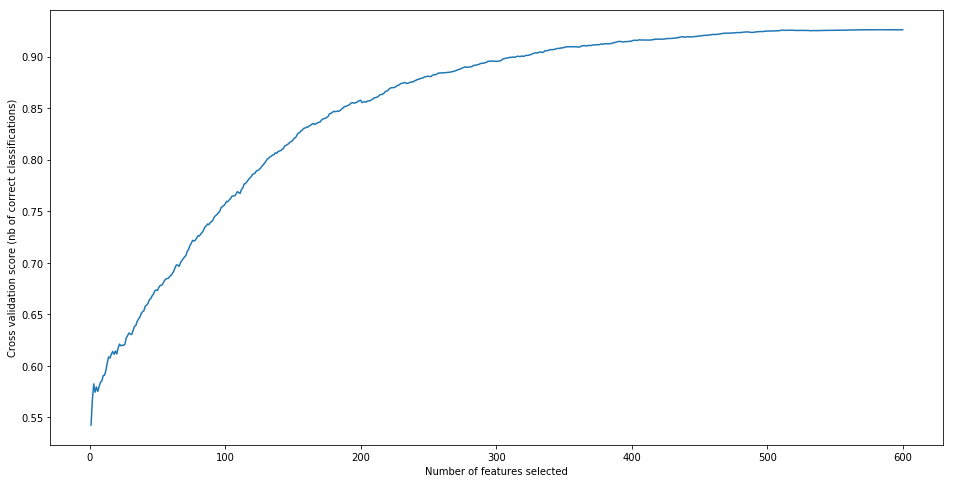

Wall time: 8min 20s


In [300]:
%%time

# I will define a logit with a relatively strong regularisation C=.1
logit = LOG(C = 10.0, penalty = 'l2', random_state = 0, class_weight = 'balanced')

X = idf6[top_features[:600]]
y = idf6.y 

rfecv = RFECV(estimator=logit, step=1, cv=StratifiedKFold(3), scoring='roc_auc')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize = (16,8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

I'll get the features that improve the model:

In [326]:
mask = []

for index, value in enumerate(rfecv.grid_scores_):
    
    if (index == len(rfecv.grid_scores_)-1):
        break 
    elif(value > rfecv.grid_scores_[index+1]):
        mask.append(False)
    else:
         mask.append(True)

In [330]:
sel_features = top_features[:599][mask]
len(sel_features)

457

With just 50 features, the Logistic regression still has a relatively 'good' prediction of the minor class. Are the top 50 variables collinear? How is the correlation and covariance matrices?

In [85]:
import seaborn as sns
def infoMatrix(df, method = 'corr'):
    
    # Compute the correlation or covariance matrix
    if method == 'corr':
        matrix = df.corr()*100
    if method == 'cov':
        matrix = df.cov()*100

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(1,200, as_cmap = True)

    plt.figure(figsize=(16, 16))
    sns.heatmap(matrix,
                cmap = cmap,
                center = 0,
                annot = False,
                linewidth = .02,
                square = True,
                cbar_kws = {"shrink": .3}
               )
    
    plt.savefig('matrix_'+method+'.pdf')
    plt.show()

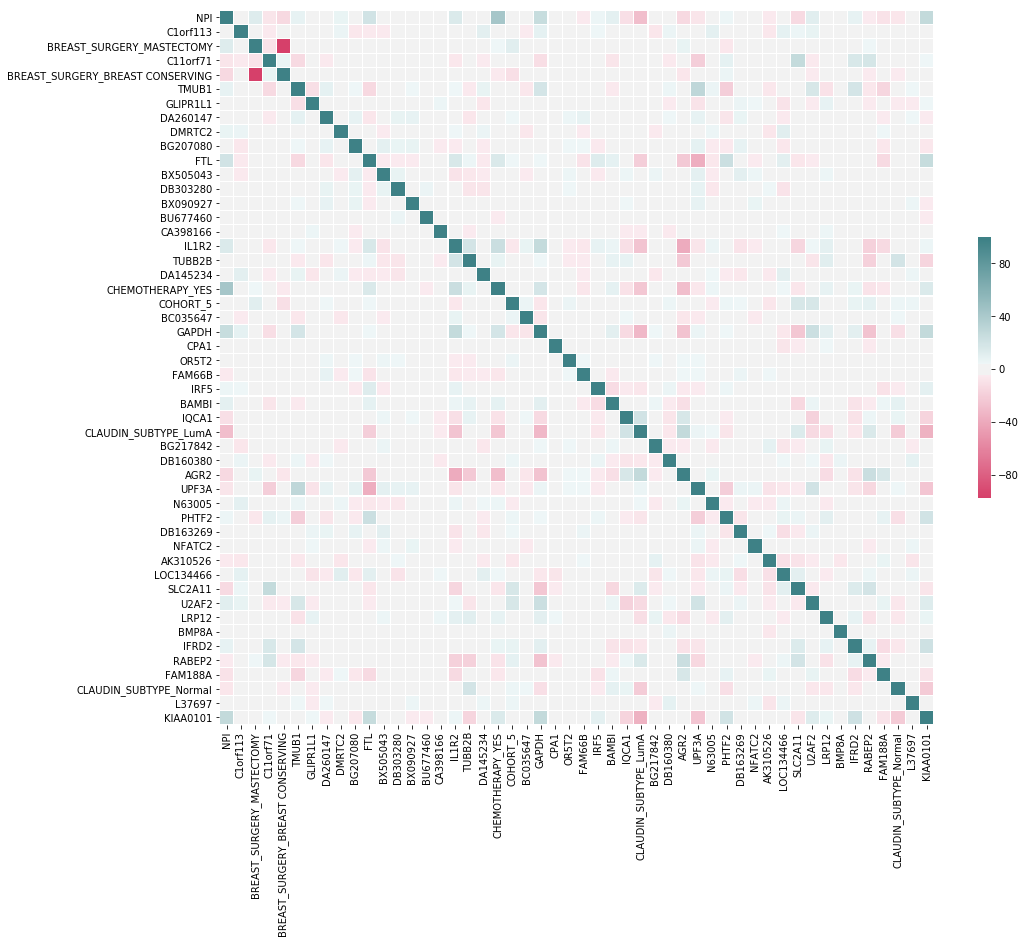

In [332]:
infoMatrix(idf6[sel_features[:50]], method = 'corr')

Not all of the features fit in the image.

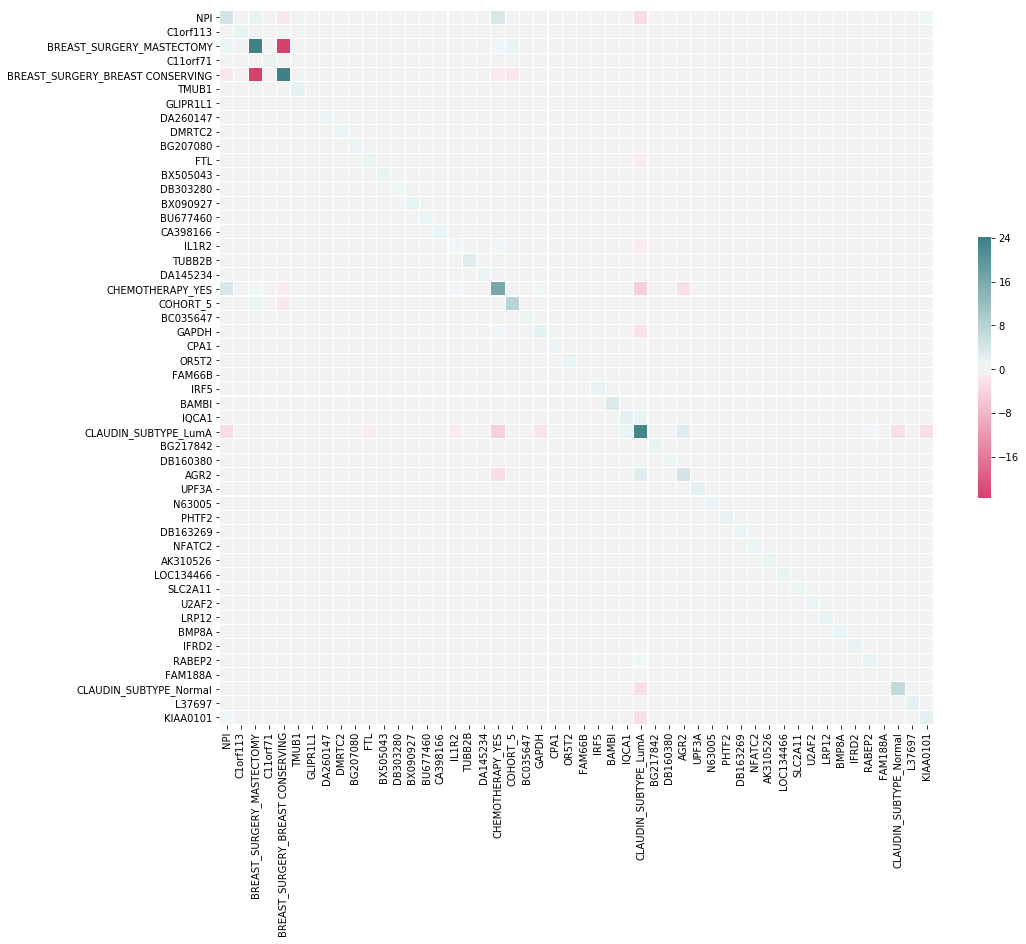

In [333]:
infoMatrix(idf6[sel_features[:50]], method = 'cov')

## 6. Biological hypothesis

But this contains the metadata, sometimes redundant features (e.g. `CHEMOTHERAPY_YES` and `CHEMOTHERAPY_NO`). Which are the most important genes without metadata?

In [131]:
print('This is the metadata:')
idf6.columns[-52:]

This is the metadata:


Index(['AGE_AT_DIAGNOSIS', 'NPI', 'y', 'COHORT_1', 'COHORT_2', 'COHORT_3',
       'COHORT_4', 'COHORT_5', 'LATERALITY_l', 'LATERALITY_null',
       'LATERALITY_r', 'ER_IHC_neg', 'ER_IHC_pos',
       'INFERRED_MENOPAUSAL_STATE_post', 'INFERRED_MENOPAUSAL_STATE_pre',
       'BREAST_SURGERY_BREAST CONSERVING', 'BREAST_SURGERY_MASTECTOMY',
       'BREAST_SURGERY_null', 'CELLULARITY_high', 'CELLULARITY_low',
       'CELLULARITY_moderate', 'CELLULARITY_null', 'HER2_SNP6_GAIN',
       'HER2_SNP6_LOSS', 'HER2_SNP6_NEUT', 'HER2_SNP6_UNDEF',
       'THREEGENE_ER+/HER2- High Prolif', 'THREEGENE_ER+/HER2- Low Prolif',
       'THREEGENE_ER-/HER2-', 'THREEGENE_HER2+', 'THREEGENE_null',
       'CLAUDIN_SUBTYPE_Basal', 'CLAUDIN_SUBTYPE_Her2', 'CLAUDIN_SUBTYPE_LumA',
       'CLAUDIN_SUBTYPE_LumB', 'CLAUDIN_SUBTYPE_NC', 'CLAUDIN_SUBTYPE_Normal',
       'CLAUDIN_SUBTYPE_claudin-low', 'CHEMOTHERAPY_NO', 'CHEMOTHERAPY_YES',
       'HORMONE_THERAPY_NO', 'HORMONE_THERAPY_YES', 'RADIO_THERAPY_NO',
       'RAD

In [334]:
meta = list(idf6.columns[-52:])
top = list(sel_features[:200])

top_genes = [x for x in top if not x in meta]

Which are these genes?

In [336]:
top_genes[:10]

['C1orf113',
 'C11orf71',
 'TMUB1',
 'GLIPR1L1',
 'DA260147',
 'DMRTC2',
 'BG207080',
 'FTL',
 'BX505043',
 'DB303280']

Ideally, all these probes will have to be related to breast cancer prognosis in blood samples (I don't know which cell lines were used for this gene expression profiling array). I'll search for a few of them to see if there's literature about their role in cancer prognosis:

1. __C1orf113__: "Significant hypermethylation of C1orf113 occurred in Human Salivary Gland Adenoid Cystic Carcinoma" https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3123690/
2. __C11orf71__: Uncharacterized protein C11orf71 up-regulated in lung cancer http://www.genecards.org/cgi-bin/carddisp.pl?gene=C11orf71 with two isoforms http://www.uniprot.org/uniprot/Q6IPW1
3. __TMUB1__: May contribute to the regulation of translation during cell-cycle progression. May contribute to the regulation of cell proliferation (By similarity). http://www.uniprot.org/uniprot/Q9BVT8
4. __GLIPR1L1__: Identification and characterization of RTVP1/GLIPR1-like genes, a novel p53 target gene cluster https://www.ncbi.nlm.nih.gov/pubmed/16714093/
5. __DA260147__: Nothing relevant https://goo.gl/Nf8Des
6. __DMRTC2__ May be involved in sexual development as a DNA binding transcription factor upon ion binding and homodimerisation. It's believed to have a positive di- and tri-metrhylation of histone H3-K9 http://www.uniprot.org/uniprot/Q8CGW9
7. __BG207080__: There's no much information https://goo.gl/UkzR9D
8. __FTL__: The expression of Ferritin Light Chain, a key protein in iron metabolism, was associated to Glioblastoma Multiforme (GBM) and that was suggested to interact with GADD45A in GBM cells, probably up-regulating the growth of GBM cells via the GADD45/JNK pathway.
9. __BX505043__: Not much information https://goo.gl/cVtJEm
10. __DB303280__: Not much information https://goo.gl/NbkAA9


Most of them are sequence probes without much literature, I'll do a second round of feature selection with a simple Logit with `statsmodels`

In [338]:
import statsmodels.api as sm

exog = idf6[top_genes]
endog = idf6.y

model = sm.Logit(endog = endog, exog = sm.add_constant(exog)).fit()

Optimization terminated successfully.
         Current function value: 0.259197
         Iterations 8


I'll sort based on the p-value and select the top 15 genes:

In [341]:
model.pvalues.sort_values()[:25]

PHTF2        0.000095
SMCR7L       0.000194
CB048155     0.000200
CAMKK2       0.000202
LOC646862    0.000302
EWSR1        0.000417
GRIN3B       0.000442
C11orf71     0.000490
BX119059     0.000555
FAM66B       0.000713
ACO1         0.001044
TUBB2B       0.001225
PLCZ1        0.001254
WIF1         0.001339
DB303280     0.001605
NAV1         0.001744
const        0.001806
WDR43        0.002037
DA260147     0.002094
L37697       0.002143
DCX          0.002166
OR5T2        0.002663
BX090927     0.002673
BG217842     0.003192
LRP12        0.003233
dtype: float64

1. __PHTF2__ is a putative homeodomain transcription factor that has been demonstrated to be an unfavorable marker in renal and thyroid cancer https://www.proteinatlas.org/ENSG00000006576-PHTF2/pathology.

2. __EWSR1__ encodes a multifunctional protein that is involved in various cellular processes, including gene expression, cell signaling, and RNA processing and transport.  Mutations in this gene, specifically at(11;22)(q24;q12) translocation, are known to cause Ewing sarcoma as well as neuroectodermal and various other tumors. Alternative splicing of this gene results in multiple transcript variants http://www.cancerindex.org/geneweb/EWSR1.htm It is involved in translocations in Ewing's sarcoma, clear cell sarcoma, desmoplastic small round cell tumor and myxoid liposarcoma. The Ewing sarcoma family of tumours is characterised by recurrent translocations that fuse EWS to one of the following genes FLI1 (>90% of cases), ERG, ETV1, E1AF and FEV. In clear cell sarcoma, DSRCT and myxoid liposarcoma EWS is fused to ATF1, WT1 and CHOP respectively.

3. __ACO1__  is a bifunctional, cytosolic protein that functions as an essential enzyme in the TCA cycle and interacts with mRNA to control the levels of iron inside cells. It is strongly associated with survival in pancreatic cancer and therefore prognosis so it can be relevant in the prediction of 3 year mortality from cancer https://www.proteinatlas.org/ENSG00000122729-ACO1/pathology, https://www.ncbi.nlm.nih.gov/gene/48

4. __WDR43__ has been demonstrated to be a bad prognostic for liver and endometrial cancers. It is a ribosome biogenesis factor, involved in nucleolar processing of pre-18S ribosomal RNA. Required for optimal pre-ribosomal RNA transcription by RNA polymerase I. https://www.proteinatlas.org/ENSG00000163811-WDR43/pathology, http://www.genecards.org/cgi-bin/carddisp.pl?gene=WDR43

5. __WIF1__ is a lipid-binding protein that binds to Wnt proteins and prevents the signalling pathway. Wnt is involved in embryonic development and a silenciation of WIF1 gene in one experiment led to the upregulation of the Wnt pathway https://en.wikipedia.org/wiki/WIF1, https://onlinelibrary.wiley.com/doi/abs/10.1002/gcc.20402, https://www.sciencedirect.com/science/article/pii/S0006291X06000428?via%3Dihub

6. __CAMKK2__ belongs to the Serine/Threonine protein kinase family, and to the Ca(2+)/calmodulin-dependent protein kinase subfamily. The camKK2/camKIV relay is an essential regulator of hepatic cancer. CaMKK2 serves as a scaffold to assemble CaMKIV with key components of the mammalian target of rapamycin/ribosomal protein S6 kinase, 70 kDa, pathway and thereby stimulate protein synthesis through protein phosphorylation https://www.ncbi.nlm.nih.gov/gene/10645. CAMKK2 signals in gastric cancer through AMPK activation and suggest that CAMKK2 could be a novel therapeutic target in gastric cancer https://www.ncbi.nlm.nih.gov/pubmed/25847065/, https://www.ncbi.nlm.nih.gov/pubmed/25756516 CAMKK2 could be regulated by promoter methylation. CAMKK2 serves as a prognostic marker in gliomas and could be a potential therapeutic target in gliomas https://www.ncbi.nlm.nih.gov/pubmed/27012733/


# 7. Dimensionality reduction
 I will use PCA and t-SNE to reduce the dimensionality and observe if with just two variables binary classifiers are still able to the two classes:

## 7.1 PCA

In [345]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6, random_state = 0)
pca.fit(idf6[sel_features[:200]].transpose())

index = 1
for i in pca.explained_variance_ratio_:
    print('Variance explained in component %-10d %.3f' % (index,i))
    index +=1

Variance explained in component 1          0.321
Variance explained in component 2          0.073
Variance explained in component 3          0.059
Variance explained in component 4          0.026
Variance explained in component 5          0.022
Variance explained in component 6          0.020


I will plot the 6 components that explain most of the variance:

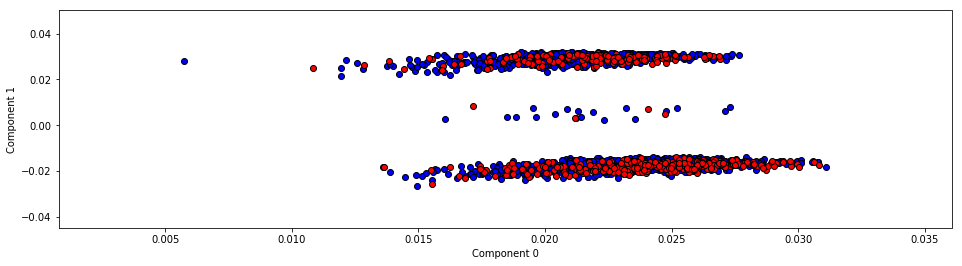

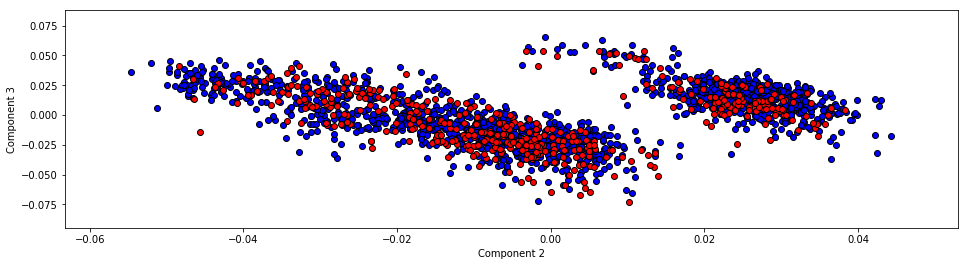

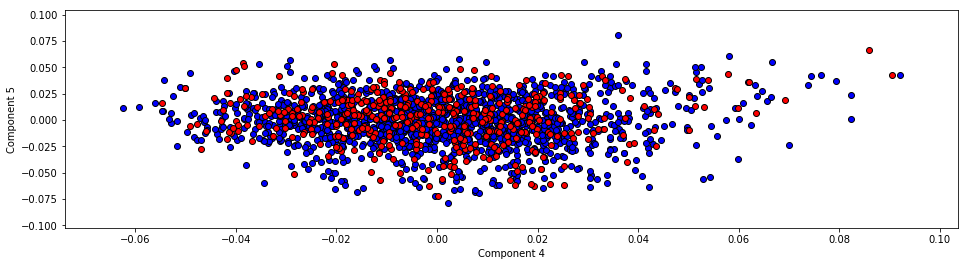

In [346]:
pca_df = pd.DataFrame(pca.components_.transpose())

for i in range(3):    
    plt.figure(figsize = (16,4))
    plt.scatter(pca_df[0+2*i][idf6.y == 0.0], pca_df[1+2*i][idf6.y==0.0], c = 'b', edgecolors='k')
    plt.scatter(pca_df[0+2*i][idf6.y == 1.0], pca_df[1+2*i][idf6.y==1.0], c = 'r', edgecolors='k')
    plt.xlabel('Component '+str(0+2*i))
    plt.ylabel('Component '+str(1+2*i))
    plt.show()

I saw this classifier comparison on sklearn website (http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) and I think it will look good with the PCA components, I'll mention the author of this code:

In [347]:
datasets = [(pca_df[[0,1]].values, idf6.y.values),
            (pca_df[[2,3]].values, idf6.y.values),
            (pca_df[[4,5]].values, idf6.y.values),
           ]

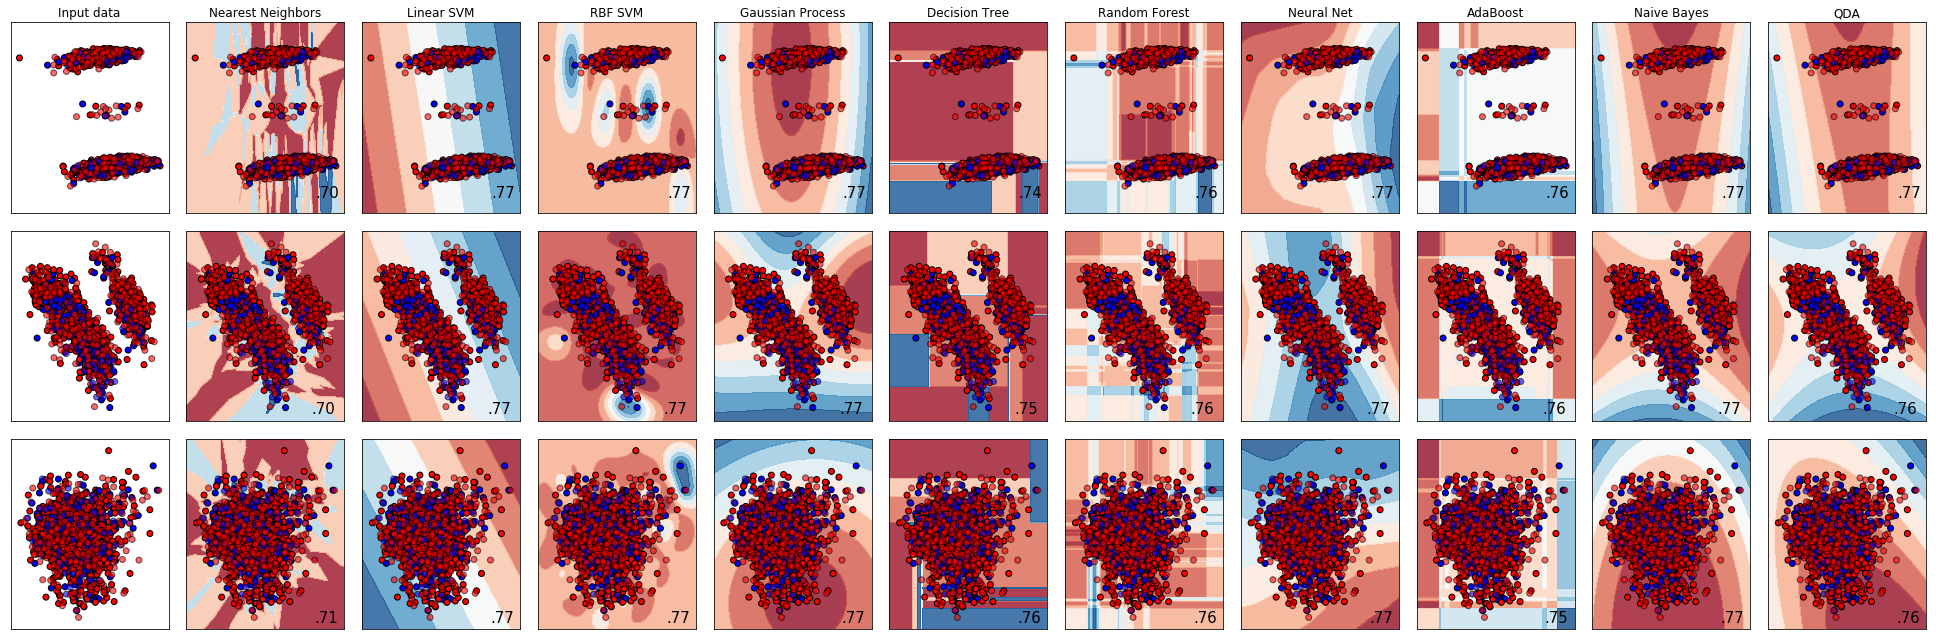

Wall time: 12min 15s


In [348]:
%%time

# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified by David Narganes
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.savefig('classifiers.pdf')
plt.show()

## 8.2 t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets (https://lvdmaaten.github.io/tsne/). It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

In [350]:
from sklearn.manifold import TSNE

In [351]:
%%time
tsne = TSNE(n_components=3,
             perplexity = 30,
             random_state=1,  # It may fall in a local minimum, it'll be better to run it x times and get CI
             n_iter = 1000,
             min_grad_norm = 1e-12,
             angle = 0.18,
           )

feat_3d = tsne.fit_transform(idf6[sel_features])

Wall time: 4min 5s


Using the information of all top features, I've reduced their information in just two components.

In [352]:
points = pd.DataFrame(feat_3d, columns = ['x','y','z'])
points['deadfdisease3y'] = idf6.y
points.head()

,x,y,z,deadfdisease3y
0,-6.824722,5.372131,55.907944,1.0
1,-12.270892,-31.129763,24.313160,0.0
2,3.492088,0.369332,-52.113941,0.0
3,3.653262,6.432721,-42.469494,0.0
4,15.286640,-7.532773,-65.804848,0.0


Are there any clusters after t-SNE?

In [353]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

x, y, z = points.x, points.y, points.z

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=7,
        color=points.deadfdisease3y,
        colorscale='Viridis',
        opacity=0.7
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

No, there are no clusters after t-SNE.

## Remaining things to do:
1. Sentitivity analysis with imputation. How is the imputation affecting the results in comparison to the non-imputed `df`? Even if the imputed values aren't many.
2. Outliers?
3. Analyse the top genes and look at their relevance as good predictors in cancer prognosis in the literature